# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [41]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [62]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


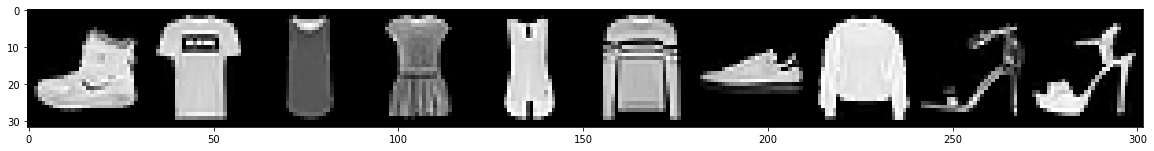

In [43]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

# Solution Task1
1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [68]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)), end='\r')


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=64)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

Named labels: 
['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker']
True labels: 
[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
Predicted: 
[9 2 1 1 6 1 4 6 5 7]


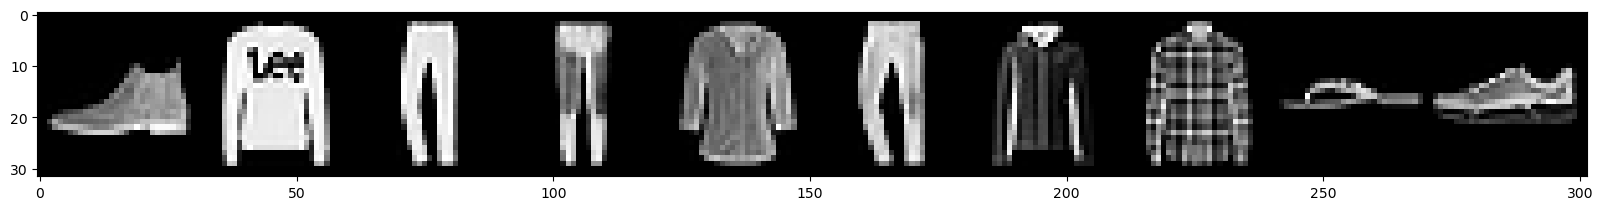

In [12]:
#visualize
x,y = zip(*[test_dataset[i] for i in range(10)])
x = torch.stack(x)
#y = torch.stack(y)
grid_img = torchvision.utils.make_grid(x, nrow=10)

plt.figure(figsize=(20,5))
plt.imshow(grid_img.permute(1, 2, 0))

labels = [idx_to_class[test_dataset[i][1]] for i in range(10)]
unnamed_labels = [test_dataset[i][1] for i in range(10)]
print('Named labels: ')
print(labels)

print('True labels: ')
print(unnamed_labels)

pred = model(x)


labels_pred = pred.max(1).indices  # Vorhergesagte Werte
labels_pred = labels_pred.numpy()


print('Predicted: ')
print(labels_pred)

precision: [0.86608863 0.99490835 0.86425781 0.91210938 0.878      0.98602794
 0.79741379 0.96520875 0.98597194 0.97294589]
recall: [0.899 0.977 0.885 0.934 0.878 0.988 0.74  0.971 0.984 0.971]
fscore: [0.88223749 0.98587286 0.87450593 0.9229249  0.878      0.98701299
 0.76763485 0.96809571 0.98498498 0.97197197]
Accuracy overall: 0.9227


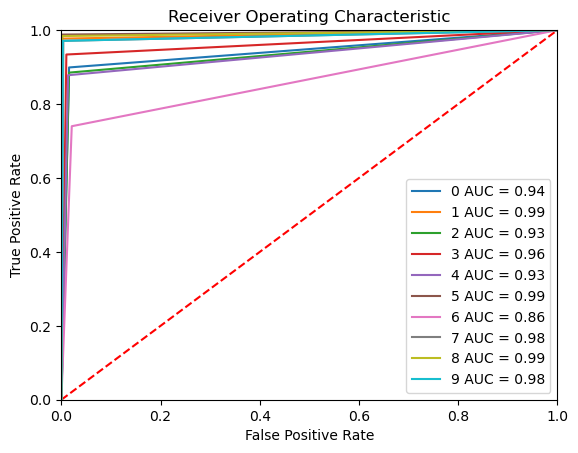

Confusion Matrix:
 [[899   1  16  13   2   1  65   0   3   0]
 [  1 977   1  16   2   0   1   0   2   0]
 [ 17   1 885   7  36   0  53   0   1   0]
 [ 12   1  11 934  21   0  20   0   1   0]
 [  0   0  50  24 878   0  48   0   0   0]
 [  0   0   0   0   0 988   0   8   0   4]
 [108   1  60  26  59   0 740   0   6   0]
 [  0   0   0   0   0   6   0 971   0  23]
 [  1   1   1   4   2   2   1   4 984   0]
 [  0   0   0   0   0   5   0  23   1 971]]


In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt

# confusion matrix
labels_true = [test_dataset[i][1] for i in range(len(test_dataset))]   # Tatsächliche Werte


x,y = zip(*[test_dataset[i] for i in range(len(test_dataset))])
x = torch.stack(x)

pred = model(x)


labels_pred = pred.max(1).indices  # Vorhergesagte Werte
labels_pred = labels_pred.numpy()

#
#print(labels_true )
#print("-----------------------------------")
#print(labels_pred )
#

def confusion_matrix(true_values, pred_values):
    unique_labels = np.unique(true_values)
    num_labels = len(unique_labels)
    cm = np.zeros((num_labels, num_labels), dtype=int)
    
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    
    for true, pred in zip(true_values, pred_values):
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]
        cm[true_index, pred_index] += 1
    
    return cm, unique_labels

# Accurac etc
accuracy = accuracy_score(labels_true, labels_pred)

precision, recall, fscore, _ = precision_recall_fscore_support(labels_true, labels_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print("Accuracy overall: {}".format(accuracy))

# ROC Curve for all labels
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')

for index in range(10):
    class_labels_true = [1 if (item == index) else 0 for item in labels_true ]
    class_labels_pred = [1 if (item == index) else 0 for item in labels_pred ]
    fpr, tpr, threshold = roc_curve(class_labels_true, class_labels_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = str(index) + ' AUC = %0.2f' % roc_auc)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Berechnen der Confusion Matrix
cm, labels = confusion_matrix(labels_true, labels_pred)
print("Confusion Matrix:\n", cm)

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [73]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


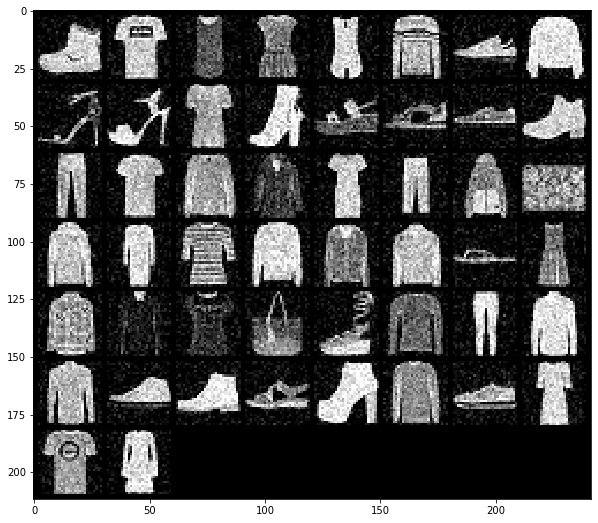

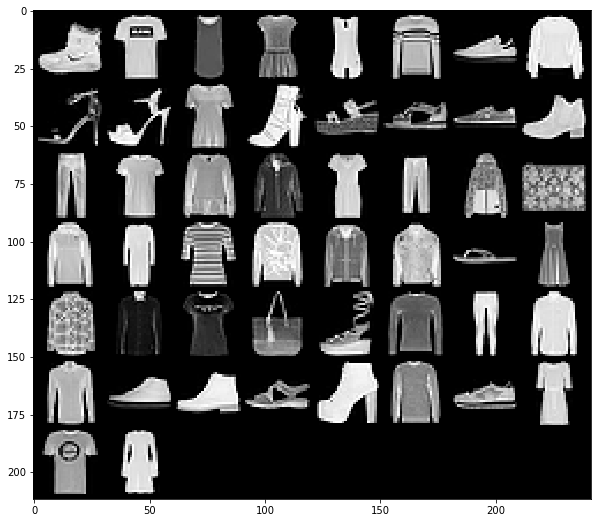

In [74]:
x = [train_dataset[i][0] for i in range(50)]
y = [train_dataset[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down_conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.down_conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.up_conv1 = nn.Conv2d(64, 32, 3, 1, 1)
        self.up_conv2 = nn.Conv2d(32, 1, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        

    def forward(self, x):
        # Down
        #x = F.max_pool2d(x, 2)
        x = self.down_conv1(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.down_conv2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        #x = F.relu(x)
        
        # Up
        #x = F.interpolate(x, 2)
        x = self.up_conv1(x)
        x = F.relu(x)
        #x = F.interpolate(x, 2)
        x = self.up_conv2(x)
        x = F.relu(x)
        #x = self.interpolate(x)
                
        ##output = F.log_softmax(x, dim=1)
        return x

In [76]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(
    test_loss, correct, len(test_loader.dataset)), end='\r')


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=64)

model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,4 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


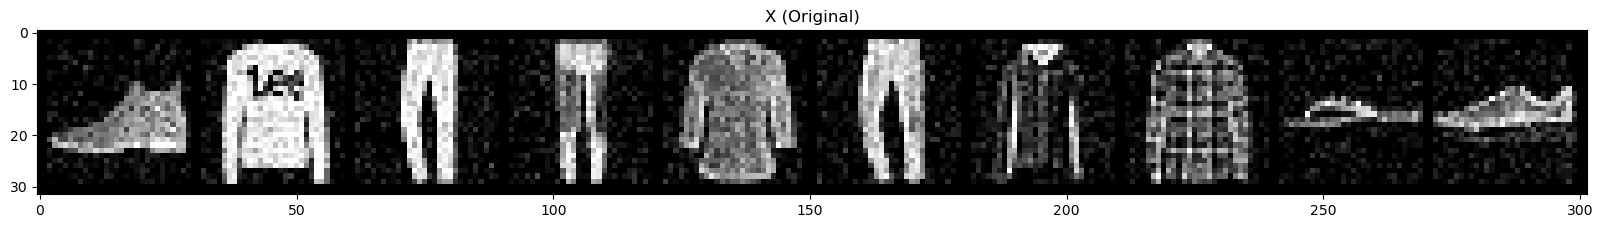

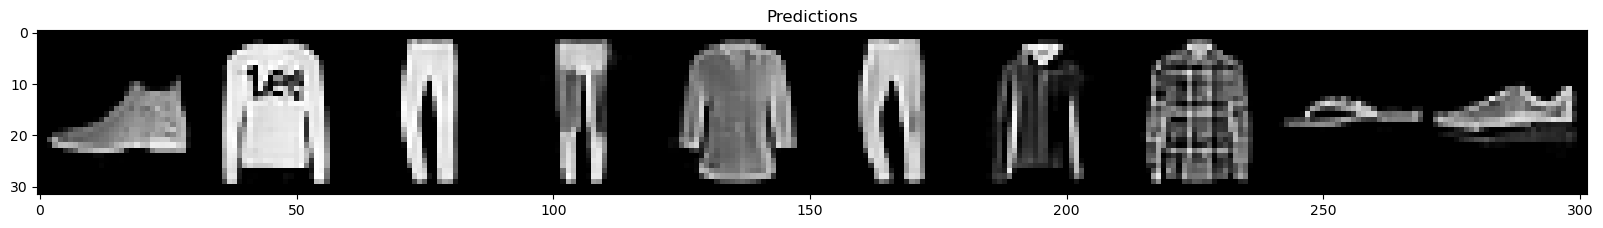

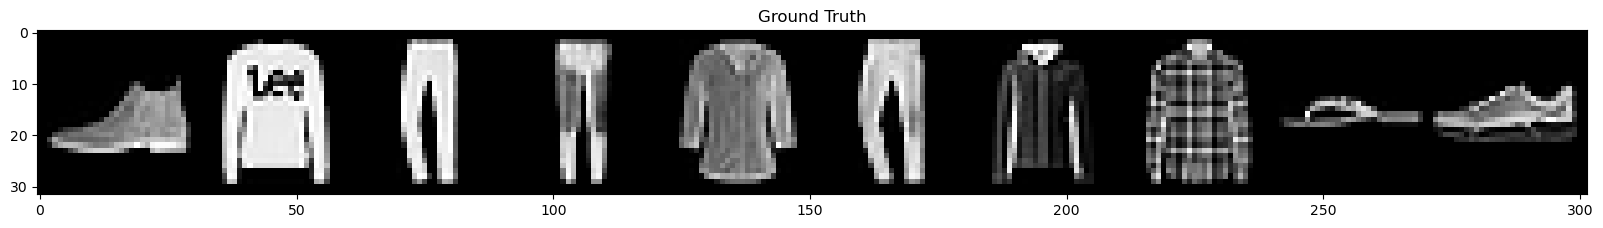

In [61]:
#visualize
x,y = zip(*[test_dataset[i] for i in range(10)])
x = torch.stack(x)
y = torch.stack(y)

def showSampleImages(data, title):
    grid_img = torchvision.utils.make_grid(data, nrow=10)
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))

showSampleImages(x, "X (Original)")

pred = model(x)
showSampleImages(pred, "Predictions")

showSampleImages(y, "Ground Truth")

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.

In [77]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

In [78]:
# Resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class Net_Res(nn.Module):
    def __init__(self):
        super(Net_Res, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 1, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6272, 128)
        self.fc2 = nn.Linear(128, 28)

    def forward(self, x):
        original_data = x
        x = self.conv1(x)
        x = F.relu(x)
        
        x = F.relu(x)
        x2 = x+ original_data
        x2 = self.conv2(x2) 
 
        x2 = F.relu(x)
        x2 = F.max_pool2d(x2, 2)
        x2 = self.dropout1(x2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc1(x2)
        x2 = F.relu(x2)
        x2 = self.dropout2(x2)
        x2 = self.fc2(x2)
        x2
        
        output = F.log_softmax(x2, dim=1)
        return output

    
    

In [79]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)), end='\r')
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=64)

model = Net_Res().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

In [ ]:
# Experiment 1: residual connection with fewer channels in convolution 1 & 2
# Results: worse performance (90% Accuracy) compared to Solution task 1 (92%)

In [69]:
# Depth
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class Net_Depth(nn.Module):
    def __init__(self):
        super(Net_Depth, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(18432, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        original_data = x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        x
        output = F.log_softmax(x, dim=1)
        return output

    
    

In [70]:
model = Net_Depth().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

In [ ]:
# Experiment 2: Higher Depth with more channels
# Results: better performance (93% Accuracy) compared to Solution task 1 (92%), more time required

In [36]:
# Batch_Normalization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class Net_Batch_Normalization(nn.Module):
    def __init__(self):
        super(Net_Batch_Normalization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.bn3 = nn.BatchNorm1d(128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x) 
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        x
        output = F.log_softmax(x, dim=1)
        return output

    
    

In [37]:
model = Net_Batch_Normalization().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

C:\Users\colin\AppData\Local\Temp\ipykernel_5424\3717334773.py:7: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, target)


RuntimeError: The size of tensor a (10) must match the size of tensor b (64) at non-singleton dimension 1

In [94]:
# Experiment 3: Batch Normalization
# Results: better performance (93% Accuracy) compared to Solution task 1 (92%)

SyntaxError: invalid syntax (2449660883.py, line 2)

In [84]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

In [85]:
# Resnet Denoising


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class UNet_Res(nn.Module):
    def __init__(self):
        super(UNet_Res, self).__init__()
        self.down_conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.down_conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.up_conv1 = nn.Conv2d(64, 32, 3, 1, 1)
        self.up_conv2 = nn.Conv2d(32, 1, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        

    def forward(self, x):
        original_data = x
        # Down
        #x = F.max_pool2d(x, 2)
        x = self.down_conv1(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.down_conv2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        #x = F.relu(x)
        
        # Up
        #x = F.interpolate(x, 2)
        x = self.up_conv1(x)
        x = F.relu(x)
        #x = F.interpolate(x, 2)
        x = self.up_conv2(x)
        x2 = x + original_data
        x2 = F.relu(x2)
        #x = self.interpolate(x)
                
        ##output = F.log_softmax(x, dim=1)
        return x2

In [86]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(
    test_loss, correct, len(test_loader.dataset)), end='\r')
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=64)
    
model = UNet_Res().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.001939
Test set: Average loss: 1.4336
Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.001907
Test set: Average loss: 1.4018
Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.001823
Test set: Average loss: 1.3759
Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.001812
Test set: Average loss: 1.3763
Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.001765
Test set: Average loss: 1.3499


KeyboardInterrupt: 

In [ ]:
# Experiment 4: Residual Connection Denoising
# Results: TODO

In [87]:
# Depth Denoising


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class UNet_Depth(nn.Module):
    def __init__(self):
        super(UNet_Depth, self).__init__()
        self.down_conv1 = nn.Conv2d(1, 64, 3, 1, 1)
        self.down_conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.up_conv1 = nn.Conv2d(128, 64, 3, 1, 1)
        self.up_conv2 = nn.Conv2d(64, 1, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        

    def forward(self, x):
        # Down
        #x = F.max_pool2d(x, 2)
        x = self.down_conv1(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.down_conv2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        #x = F.relu(x)
        
        # Up
        #x = F.interpolate(x, 2)
        x = self.up_conv1(x)
        x = F.relu(x)
        #x = F.interpolate(x, 2)
        x = self.up_conv2(x)
        x = F.relu(x)
        #x = self.interpolate(x)
                
        ##output = F.log_softmax(x, dim=1)
        return x

In [88]:
model = UNet_Depth().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

In [ ]:
# Experiment 5: Higher Depth with more channels Denoising
# Results: TODO

In [92]:
# Batch Normalization Denoising


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

class UNet_Batch_Normalization(nn.Module):
    def __init__(self):
        super(UNet_Batch_Normalization, self).__init__()
        self.down_conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32) 
        self.down_conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64) 
        self.up_conv1 = nn.Conv2d(64, 32, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(32) 
        self.up_conv2 = nn.Conv2d(32, 1, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(1) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        

    def forward(self, x):
        # Down
        #x = F.max_pool2d(x, 2)
        x = self.down_conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.down_conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        #x = F.relu(x)
        
        # Up
        #x = F.interpolate(x, 2)
        x = self.up_conv1(x)
        x = self.bn3(x)
        x = F.relu(x)
        #x = F.interpolate(x, 2)
        x = self.up_conv2(x)
        x = self.bn4(x)
        x = F.relu(x)
        #x = self.interpolate(x)
                
        ##output = F.log_softmax(x, dim=1)
        return x

In [96]:
model = UNet_Batch_Normalization().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1,10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

KeyboardInterrupt: 

In [97]:
# Experiment 6: Batch Normalization Denoising
# Results: TODO

NameError: name 'TODO' is not defined